# Diabetes Challenge - Solution

**This notebook contains a basic analysis of the dataset, considerations for the choice of the evaluation metric, and the implementation of knn/decision tree with GridSearchCV to tune the hyperparameters.**

# Data Description

## About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction| Diabetes pedigree function|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

## Set-up and Import

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data import
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

We will import the data from the database using sqlalchemy. After we imported the data we can directly save it as a .csv file so we don't have to run the query every time we want to execute the notebook.

In [2]:
##read the database string from the .env
#load_dotenv()
#
#DB_STRING = os.getenv('DB_STRING')
#
#db = create_engine(DB_STRING)

In [3]:
## import the data to a pandas dataframe
#query_string = "SELECT * FROM datasets.diabetes"
#df = pd.read_sql(query_string, db)

In [4]:
##export the data to a csv-file
#df.to_csv('data/diabetes.csv',index=False)

In [5]:
df = pd.read_csv('data/diabetes.csv')

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## The Data
Before starting to build and train a model we have to explore and maybe also clean the data. 

In [7]:
#Print the shape of the data
print('Diabetes dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Diabetes dataset
# observations: 768
# features:     8


As we can see, the dataset contains 768 observations and 9 columns from which the last column defines the label, i.e. the test result. 
Thus, we have 8 independent features.

Let us take a look at the single variables included in the dataset:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [10]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

From the output above we could assume that the data is already rather clean with no missing values, but the summary we get with `.describe()` should make us wonder... We definitely have to check if in our case maybe missing values are represented by zeros. Before we have a closer look at the data and try to impute values, we will split our data into train and test set to make sure our test data will be not "contaminated" by information from the train data and vice versa.

## Train test split

[Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) is a statistical method that allows us to sample observations from data that is partitioned into subgroups. Here: subgroups defined by the label, i.e. a positive or negative test result. Using this method, we can ensure that the data distributions in the training and test sets are nearly the same. This is useful because the data distribution we want to apply the model to later should be identical to the one we train the model on. 

For the test set we will use 33% of the available data. In cases where the amount of data is limited we should carefully separate enough data into the test set so we can ensure later that the model generalizes well enough to new data. The ratio of between training and test data increases with the amount of data. In case of a large data set - say 10 million entries - we can easily reduce the test set to only 1% of the data - still 100,000 observations.

In the train-test split we apply stratification which samples us the train and test data in such a way that the same ratios of positive and negative labels occur in train and test data. To get the ratio to be applied in stratification we need to provide the data along which the ratio that should be computed - here the labels. 

In [11]:
# Stratified train-test-split
df_train, df_test= train_test_split(df, test_size=0.33, random_state=42, stratify=df.Outcome)

In [12]:
# Print shape of datasets
print('Train data')
print('# df_train:     {}'.format(df_train.shape[0]))
print('==================')
print('Test data')
print('# df_test:     {}'.format(df_test.shape[0]))

Train data
# df_train:     514
Test data
# df_test:     254


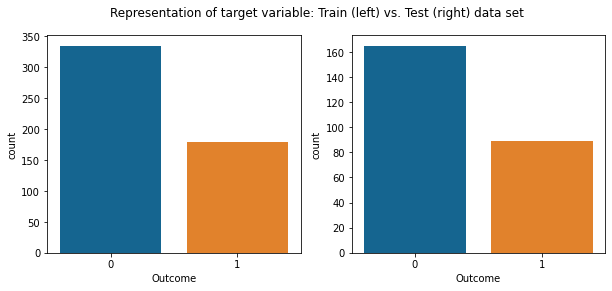

In [13]:
# Visualize y_train and y_test
fig, axes = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Representation of target variable: Train (left) vs. Test (right) data set")
sns.countplot(x=df_train.Outcome, ax=axes[0]);
sns.countplot(x=df_test.Outcome, ax=axes[1]);

## Exploration and Cleaning


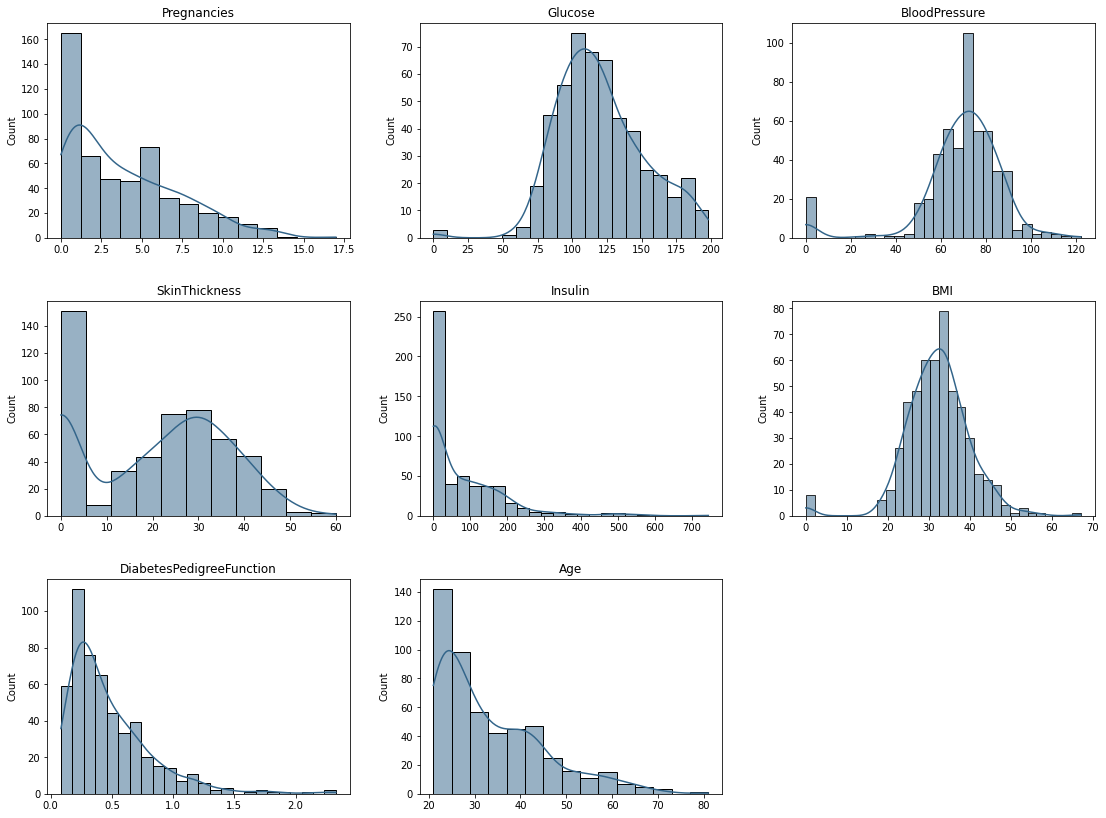

In [14]:
# Plot distribution of features 
features = df_train.columns.tolist()
features.remove('Outcome')

fig,ax = plt.subplots(3,3,figsize=(16,12))
count = 0
for item in features:
    sns.histplot(df_train[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

These plots clearly show several things:
* The distributions of `Pregnancies`, `Age`, `Insulin` and `DiabetesPedigreeFunction` are positively/right skewed. Transforming them might increase our model's performance (depending on the model type we use).
* The features `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` include zeros, even if it is not a expected value for those features. This might indicate, that missing values are represented as zeros in this dataset. We have to find a suitable strategy to replace/impute those values. 

### Analysis of Missing Values (== 0)

In [15]:
# Replace zeros with np.nan
def replace_zeros(df, feature):
    df[feature] = df[feature].replace(0, np.nan)
    return df

columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in columns_with_zeros:
    df_train = replace_zeros(df_train, col)

In [16]:
# Check for missing data
df_train.isnull().sum()

Pregnancies                   0
Glucose                       3
BloodPressure                21
SkinThickness               151
Insulin                     249
BMI                           8
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Insulin and SkinThickness have a lot of missing values. Let's start by looking at the columns with fewer missings and try to replace/drop them.

In [17]:
print(df_train.query("BMI.isnull() & BloodPressure.isnull()").shape[0])
index_list = df_train.query("BMI.isnull() & BloodPressure.isnull()").index.tolist()
df_train.query("BMI.isnull() & BloodPressure.isnull()")

5


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
60,2,84.0,NaN,NaN,NaN,NaN,0.304,21,0
426,0,94.0,NaN,NaN,NaN,NaN,0.256,25,0
522,6,114.0,NaN,NaN,NaN,NaN,0.189,26,0
49,7,105.0,NaN,NaN,NaN,NaN,0.305,24,0
706,10,115.0,NaN,NaN,NaN,NaN,0.261,30,1


There are 5 observations with missing values in 4 of 8 features. We will drop those rows.

In [18]:
# Drop rows by index
df_train = df_train.drop(index_list)

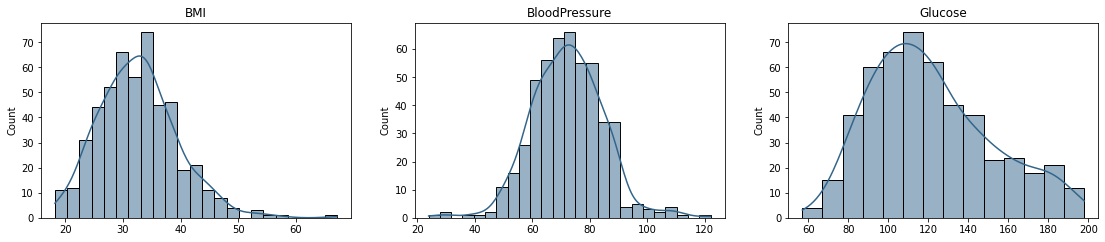

In [19]:
# Plot distribution of numerical features with missing values 
plot_col = ['BMI', 'BloodPressure', 'Glucose']
fig,ax = plt.subplots(1, 3,figsize=(16,4))
count = 0
for col in plot_col:
    sns.histplot(df_train[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    #plt.axvlines(X_train[col].mean(), 0, X_train[col].max(), color="red")
    count += 1
fig.tight_layout(pad=3)

In [20]:
# Print mean and median for those features
for col in plot_col:
    print(f"{col} mean: {df_train[col].mean().round(2)}")
    print(f"{col} median: {df_train[col].median().round(2)}")

BMI mean: 32.66
BMI median: 32.4
BloodPressure mean: 72.3
BloodPressure median: 72.0
Glucose mean: 121.4
Glucose median: 117.0


For a first try, we will replace the missing values for those columns either with the mean or median. It makes sense to check the distribution to decide which value to choose. Comparing the mean and median for those columns shows, that both values for BMI and BloodPressure are pretty close together. Only the heavies skewed column Glucose shows a remarkable difference between mean and median. We will keep it simple and replace all missing values with the median of the respective features. 

In [21]:
# Replace missing values with median of respective feature
values_dict = {}
for col in plot_col:
    values_dict[col] = df_train[col].median()
    df_train[col] = df_train[col].fillna(values_dict[col])

In [22]:
# Check for missings again
df_train.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               146
Insulin                     244
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [23]:
print("SkinThickness % of missing data:", ((df_train.SkinThickness.isnull().sum()/df_train.shape[0])*100).round(2))
print("Insulin % of missing data:", ((df_train.Insulin.isnull().sum()/df_train.shape[0])*100).round(2))

SkinThickness % of missing data: 28.68
Insulin % of missing data: 47.94


There are still two columns where a high proportion of the data is missing. Replacing them with the mean or median might induce inaccuracies. We can have a look if there are other features, which are strongly correlated so that we can drop the ones with the missing values.

### Correlations

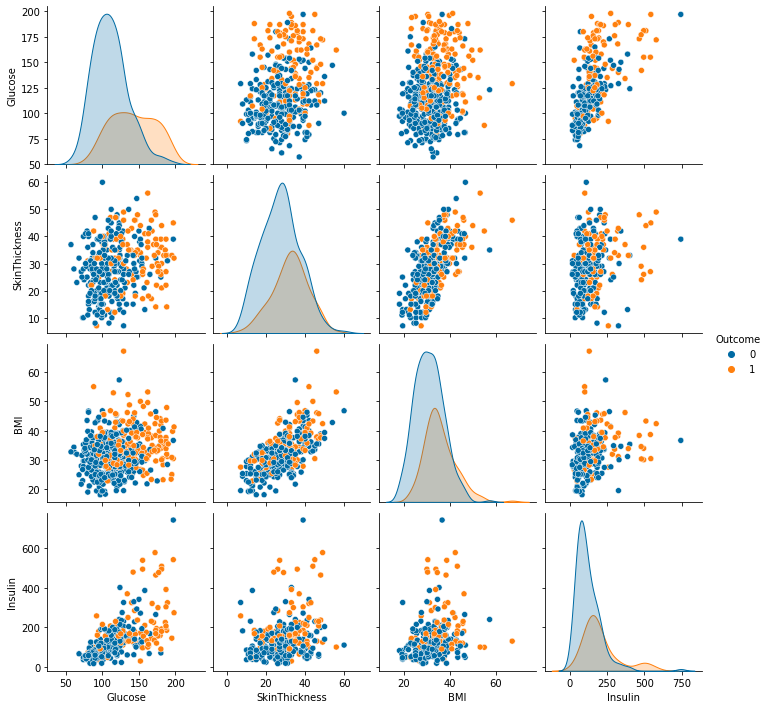

In [24]:
sns.pairplot(df_train[["Glucose", "SkinThickness", "BMI", "Insulin", "Outcome"]], hue="Outcome");

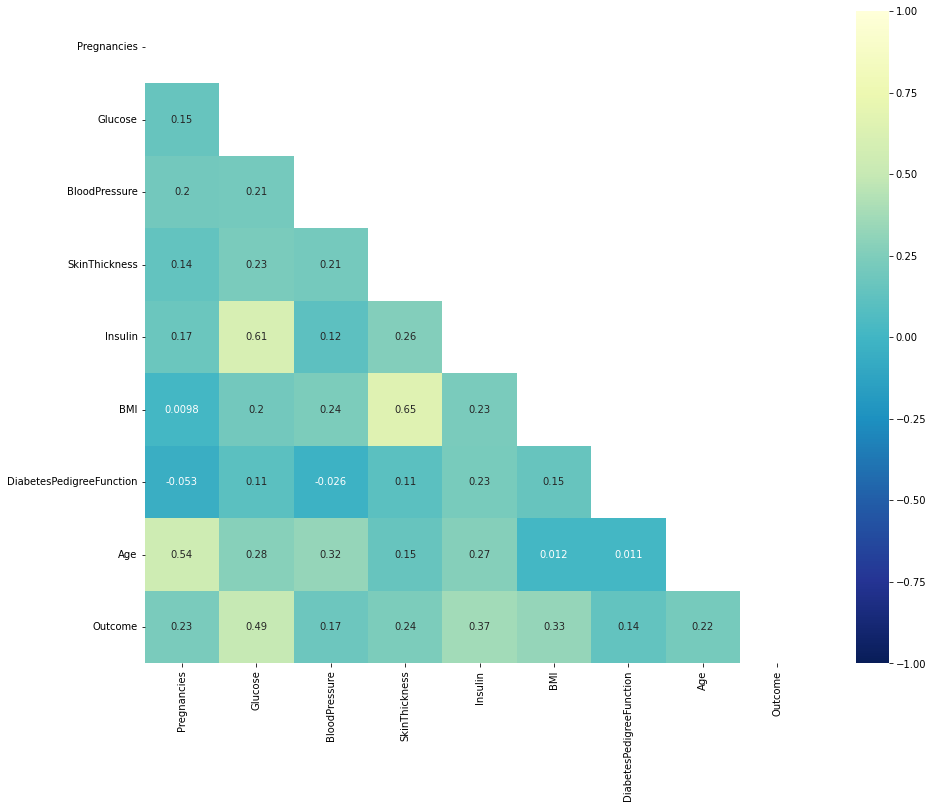

In [25]:
# Calculate correlations between features
corr = df_train.corr()

plt.subplots(figsize=(15, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="YlGnBu_r", mask=mask, vmax=1, vmin=-1);

From the pairplot and correlation heatmap above we can see that the features `BMI` and `SkinThickness` are rather highly correlated. The same applies for the features `Glucose` and `Insulin`. Since we have so many missing values for `SkinThickness` and `Insulin` we will drop them now.

In [26]:
# Drop Insulin and SkinThickness column
df_train = df_train.drop(["Insulin", "SkinThickness"], axis=1)

In [27]:
df_train.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
657,1,120.0,80.0,38.9,1.162,41,0
125,1,88.0,30.0,55.0,0.496,26,1


In [28]:
# Check for missings AGAIN
df_train.isnull().sum().sum()

0

## Preparing the Test Set

We have replaced missing values and dropped some columns in our train data. We need to prepare our test data the same way to be able to make proper predictions. To fill in the missing values we will use the median we calculated on the training set and stored in `values_dict`.

In [29]:
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
373,2,105,58,40,94,34.9,0.225,25,0
164,0,131,88,0,0,31.6,0.743,32,1


In [30]:
# Convert zeros to nan values
for col in columns_with_zeros:
    df_test = replace_zeros(df_test, col)

df_test.isnull().sum()

Pregnancies                   0
Glucose                       2
BloodPressure                14
SkinThickness                76
Insulin                     125
BMI                           3
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [31]:
# Replace missing values in test set with median from train set
for col in plot_col:
    df_test[col] = df_test[col].fillna(values_dict[col])
    
df_test.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness                76
Insulin                     125
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [32]:
# Drop columns
df_test = df_test.drop(['Insulin', 'SkinThickness'], axis=1)
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
373,2,105.0,58.0,34.9,0.225,25,0
164,0,131.0,88.0,31.6,0.743,32,1


In [33]:
# Check for missings AGAIN
df_test.isnull().sum().sum()

0

## Scaling the Data

Before we can scale the data we need to remove our target column.

In [34]:
# Split into features and target 
X_train = df_train.drop("Outcome", axis=1)
y_train = df_train.Outcome
print(X_train.shape)

(509, 6)


In [35]:
# Split test set into features and target
X_test = df_test.drop("Outcome", axis=1)
y_test = df_test.Outcome
print(X_test.shape)

(254, 6)


In [36]:
# Standardizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Target

As we have a binary outcome it is always good practice to analyze how balanced the output classes are. 

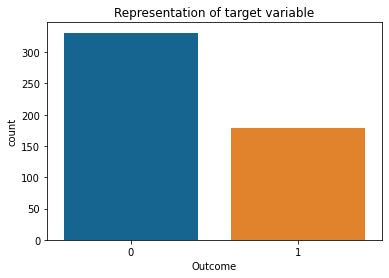

In [37]:
# Visual representation of target variable
sns.countplot(x=df_train.Outcome).set_title("Representation of target variable");

We see the classes can not be considered as balanced and therefore it might help to apply a suitable balancing method. In this case we will use the `RandomOverSampler()` from the `imblearn` package. 

In [38]:
# Oversample training data
ros = RandomOverSampler(random_state=42)
X_train_scaled_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

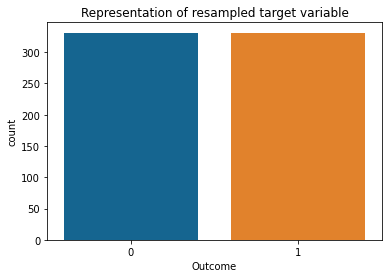

In [39]:
# Visual representation of resampled target variable
sns.countplot(x=y_train_ros).set_title("Representation of resampled target variable");

## Model building and testing

Before we start modelling we should think about which **metric** is most appropriate for our case. As we are considering diabetes test results we want to identify all patients that indeed have this disease to avoid any (further) damage or complications.

**Therefore, we go for recall (remember, $\text{Recall}=\frac{TP}{TP + FN}$) on the one hand.**

Since we don't want to ignore the precision completely, we can find a compromise by having another look on the **fbeta score with a higher weight for recall.**

In [40]:
# Define fbeta score with higher weighted recall
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Define dictionary with several interesting metrics
scorer_dict = {"ftwo_scorer": make_scorer(fbeta_score, beta=2), "accuracy": "accuracy", "precision": "precision", "recall": "recall"}

### Baseline Model

Before we start training our first model, we should define a proper baseline model. This baseline model represents a educated guess and acts as a benchmark for any further models to beat. From the exploration of our data we can see that the glucose value is a good indicator if someone has diabetes or not. We will choose a value of 130 as the cutoff. For our baseline model we will predict that everyone with a glucose value higher than 130 suffers from diabetes. 

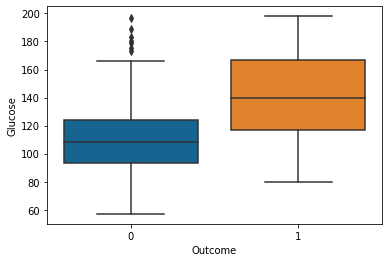

In [41]:
# Glucose value for both outcomes
sns.boxplot(x=df_train.Outcome, y=df_train.Glucose);

In [42]:
# Defining baseline model
def baseline_model(df):
    y_pred = [1 if x > 130 else 0 for x in df.Glucose]
    return y_pred

In [43]:
# Make predictions 
y_pred = baseline_model(X_test)

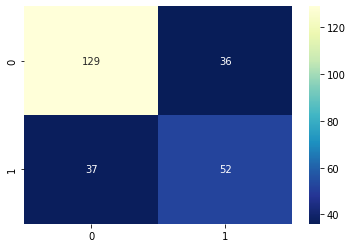

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

In [45]:
print("Fbeta score with higher weighted recall: ", fbeta_score(df_test.Outcome, y_pred, beta=2).round(3))

Fbeta score with higher weighted recall:  0.586


In [46]:
print(classification_report(df_test.Outcome, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       165
           1       0.59      0.58      0.59        89

    accuracy                           0.71       254
   macro avg       0.68      0.68      0.68       254
weighted avg       0.71      0.71      0.71       254



Our baseline model reaches a accuracy of 71% and what is even more important a **recall of 58%**. That is the value we have to beat with our more sophisticated models.

### Predictive Modeling

After we got our benchmark via the baseline model, we can now test different model types to figure out which ones can handle our data. We will pick the two most promising ones for further fine tuning of the hyperparameters. 

In [47]:
def model_evaluation(clf, scoring, X_train, y_train):
    
    results = {}
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results = {key: [value.mean().round(4), value.std().round(4)] for key, value in scores.items()}
    
    del results['fit_time']
    del results['score_time']
    
    return results

In [48]:
# Test different types of models
list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state=42)]

for clf in list_of_clf:
    #results = model_evaluation(clf, ['accuracy', 'recall', 'precision', scorer_dict['ftwo_scorer']], X_train_scaled, y_train)
    results = model_evaluation(clf, scorer_dict, X_train_scaled_ros, y_train_ros)
    print(clf)
    print("Accuracy  (mean, std):", results["test_accuracy"])
    print("Recall    (mean, std):", results["test_recall"])
    print("Precision (mean, std):", results["test_precision"])
    print("Fbeta     (mean, std):", results["test_ftwo_scorer"])
    print("----"*10)

LogisticRegression()
Accuracy  (mean, std): [0.7478, 0.0361]
Recall    (mean, std): [0.7127, 0.0593]
Precision (mean, std): [0.7675, 0.0424]
Fbeta     (mean, std): [0.7222, 0.0508]
----------------------------------------
KNeighborsClassifier()
Accuracy  (mean, std): [0.7886, 0.0385]
Recall    (mean, std): [0.8339, 0.0476]
Precision (mean, std): [0.7663, 0.043]
Fbeta     (mean, std): [0.8188, 0.0404]
----------------------------------------
SVC()
Accuracy  (mean, std): [0.7751, 0.0536]
Recall    (mean, std): [0.7914, 0.0395]
Precision (mean, std): [0.7698, 0.0647]
Fbeta     (mean, std): [0.7864, 0.0408]
----------------------------------------
DecisionTreeClassifier(random_state=42)
Accuracy  (mean, std): [0.8068, 0.0577]
Recall    (mean, std): [0.8613, 0.1169]
Precision (mean, std): [0.7768, 0.0372]
Fbeta     (mean, std): [0.8407, 0.0929]
----------------------------------------


If we compare the metrics of the trained models above, we can see that the decision tree performs rather good, followed by KNN.

#### Hyperparameter Tuning of Decision Tree

In [49]:
# Define param grid
param_grid = {'criterion':  ['gini', 'entropy'],
              'max_depth': np.arange(5,70,5),
              'min_samples_split': np.arange(5,30, 5)}

# Passing model, parametergrid and 5-fold cross validation to GridSearchCV
dec_tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1, scoring=ftwo_scorer)

# Fitting GridSearchCV will output all parameters passed
dec_tree_gs.fit(X_train_scaled_ros, y_train_ros)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25])},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [50]:
# Returning best score (recall) after GridSearch and parameter combination
print("                Best score:", dec_tree_gs.best_score_.round(4))
print("Best parameter combination:", dec_tree_gs.best_params_)
dec_tree_best = dec_tree_gs.best_estimator_

                Best score: 0.8352
Best parameter combination: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}


#### Hyperparameter Tuning of KNN

In [51]:
# In case of knn the parameters to be tuned are n_neighbors and the distance metric p
param_grid = {'n_neighbors': np.arange(2,50),
             'p': [1, 2]}

# Passing model, parametergrid and 5-fold cross validation to GridSearchCV
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1, scoring=ftwo_scorer)

# Fitting GridSearchCV 
knn_gs.fit(X_train_scaled_ros, y_train_ros)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'p': [1, 2]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [52]:
# Returning best score (recall) after GridSearch and parameter combination
print("                Best score:", knn_gs.best_score_.round(4))
print("Best parameter combination:", knn_gs.best_params_)
knn_best = knn_gs.best_estimator_

                Best score: 0.8205
Best parameter combination: {'n_neighbors': 7, 'p': 1}


### Model Evaluation

#### Decison Tree

Decision trees tend to overfit the data and this can be clearly seen here! We have nearly perfect scores on our train data, but on the test data the performance is remarkably worse. One option would be to further regularize the model, or we can try to combat overfitting by using an ensemble model which is based on decision trees (e.g. Random Forest).

Decision Tree on train data
fbeta score: 0.9818
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       331
           1       0.99      0.98      0.99       331

    accuracy                           0.99       662
   macro avg       0.99      0.99      0.99       662
weighted avg       0.99      0.99      0.99       662

------------------------------------------------------------


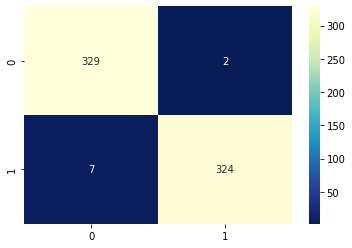

In [53]:
# Plot confusion matrix and classification report for best knn model
y_train_pred_dt = dec_tree_best.predict(X_train_scaled_ros)

print("Decision Tree on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train_ros, y_train_pred_dt, beta=2).round(4))
print("---"*20)
print(classification_report(y_train_ros, y_train_pred_dt))
print("---"*20)

cm = confusion_matrix(y_train_ros, y_train_pred_dt)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

Decision Tree on test data
fbeta score: 0.5928
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       165
           1       0.58      0.60      0.59        89

    accuracy                           0.71       254
   macro avg       0.68      0.68      0.68       254
weighted avg       0.71      0.71      0.71       254

------------------------------------------------------------


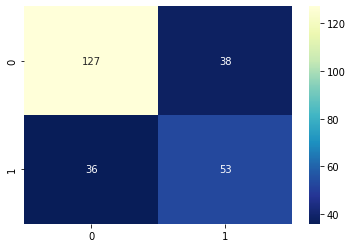

In [54]:
# Plot confusion matrix and classification report for best knn model
y_test_pred_dt = dec_tree_best.predict(X_test_scaled)

print("Decision Tree on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_dt, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_dt))
print("---"*20)

cm = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### Model Evaluation

##### KNN

Our KNN model is also slightly overfitting. That is one of the issues one might encounter when balancing the data with oversampling. But it is still performing better on the test set than the decision tree and it is also beating the benchmark from our baseline model!

KNN on train data
fbeta score: 0.8498
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       331
           1       0.82      0.86      0.84       331

    accuracy                           0.83       662
   macro avg       0.83      0.83      0.83       662
weighted avg       0.83      0.83      0.83       662

------------------------------------------------------------


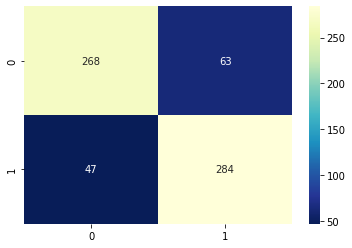

In [55]:
# Plot confusion matrix and classification report for best knn model
y_train_pred_knn = knn_best.predict(X_train_scaled_ros)

print("KNN on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train_ros, y_train_pred_knn, beta=2).round(4))
print("---"*20)
print(classification_report(y_train_ros, y_train_pred_knn))
print("---"*20)

cm = confusion_matrix(y_train_ros, y_train_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

KNN on test data
fbeta score: 0.6848
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       165
           1       0.61      0.71      0.65        89

    accuracy                           0.74       254
   macro avg       0.72      0.73      0.72       254
weighted avg       0.75      0.74      0.74       254

------------------------------------------------------------


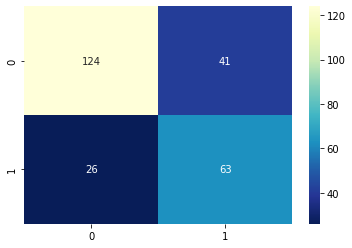

In [56]:
# Plot confusion matrix and classification report for best knn model
y_test_pred_knn = knn_best.predict(X_test_scaled)

print("KNN on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)

cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Error analysis

Let's see where our KNN model has problems differentiating between the classes.

In [57]:
correct = []
for pred, true in zip(y_test_pred_knn, y_test):
    if pred == true and pred==1:
        correct.append("TP")
    if pred == true and pred==0:
        correct.append("TN")
    if pred != true and pred==1:
        correct.append("FP")
    if pred != true and pred==0:
        correct.append("FN")

df_test["correct"] = correct
df_test.head(2)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,correct
373,2,105.0,58.0,34.9,0.225,25,0,TN
164,0,131.0,88.0,31.6,0.743,32,1,FN


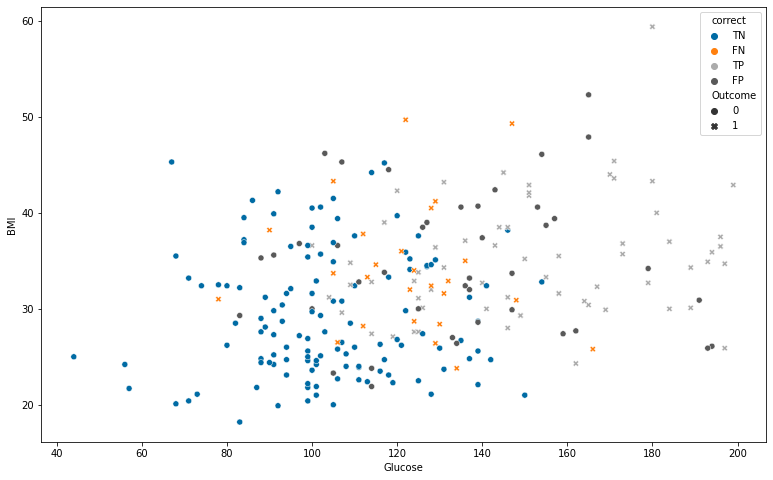

In [58]:
# Create exemplary scatterplot for two features
plt.subplots(figsize=(13,8))
sns.scatterplot(data=df_test, x="Glucose", y="BMI", hue="correct", style="Outcome");

From a plot like the one above we can try to draw some conclusions:
- people with too high glucose concentration in blood will generally be predicted as diabetes patients (even if they are not (FP))
- people with relatively low BMIs and Glucose levels will usually be predicted as healthy

Of course the outcome depends on more than those features. We could also have a closer look at other feature combinations to see if we can find patterns.